<a href="https://colab.research.google.com/github/Mengzhe/FreddieMacMortgageProject/blob/main/step1_filter_terminated_mortgages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download data

In [ ]:
import os

In [ ]:
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2011.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2012.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2013.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2014.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2015.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2016.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2017.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2018.zip"
!unzip -o "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2019.zip"

!unzip -o "*.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2011.zip
 extracting: historical_data_2011Q1.zip  
 extracting: historical_data_2011Q2.zip  
 extracting: historical_data_2011Q3.zip  
 extracting: historical_data_2011Q4.zip  
Archive:  /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2012.zip
 extracting: historical_data_2012Q1.zip  
 extracting: historical_data_2012Q2.zip  
 extracting: historical_data_2012Q3.zip  
 extracting: historical_data_2012Q4.zip  
Archive:  /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2013.zip
 extracting: historical_data_2013Q1.zip  
 extracting: historical_data_2013Q2.zip  
 extracting: historical_data_2013Q3.zip  
 extracting: historical_data_2013Q4.zip  
Archive:  /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/historical_data_2014.zip
 extracting: historical_data_2014Q1.zip  
 extracting: histo

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, 
                             roc_auc_score, 
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import joblib

# import shap
import warnings
import time
warnings.filterwarnings("ignore")

import json
from collections import defaultdict

from datetime import datetime
import pytz
from datetime import date

# from bayes_opt import BayesianOptimization

# trained_model_folder_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/"

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load Monthly Performance Data
Use zero balance code to filter data

In [ ]:
years = range(2011, 2020)

In [ ]:
df_data_dict_monthly = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/FreddieMac/file_layout.xlsx', 
                             sheet_name='Monthly Performance Data File', 
                             header=1)

columns_rename_mapper_monthly = {'Estimated Loan-to-Value (ELTV)': 'est_ltv',
                                'Monthly Reporting Period': 'rep_period',
                                # 'Current Deferred UPB': 'deferred_upb', 
                                'Current Interest Rate': 'int_rate', 
                                'Remaining Months to Legal Maturity': 'remaining_months', 
                                'Loan Age': 'loan_age', 
                                'Current Loan Delinquency Status': 'loan_status', 
                                'Current Actual UPB': 'actual_upb', 
                                'Loan Sequence Number': 'loan_id', 
                                #  'Repurchase Flag': 'repur_flag', 
                                #  'Modification Flag': 'mod_flag', 
                                 'Zero Balance Code': 'zero_bal_code', 
                                #  'Zero Balance Effective Date': 'zero_bal_d', 
                                #  'Due Date of Last Paid Installment (DDLPI)': 'ddlpi',
                                 'Delinquency Due to Disaster': 'delq_by_disaster',
                                }


cols_to_del = ['Non MI Recoveries', 'Net Sales Proceeds', 
                'Delinquent Accrued Interest', 'Actual Loss Calculation',
                'Miscellaneous Expenses', 'Taxes and Insurance', 
                'Maintenance and Preservation Costs', 'Legal Costs', 
                'Expenses', 'MI Recoveries', 'Step Modification Flag', 
                'Modification Flag', 'Deferred Payment Plan', 'Modification Cost', 
                'Current Month Modification Cost', 'Borrower Assistance Status Code',
                'Due Date of Last Paid Installment (DDLPI)', 
                'Repurchase Flag', 'Zero Balance Removal UPB', 
                'Zero Balance Effective Date', 
            #  'Zero Balance Code',
                'Current Deferred UPB',
                ]

In [ ]:
%%time
np.random.seed(0)
selected_loan_idxes_paid = set()
selected_loan_idxes_charged = set()
df_list = []
path_monthly_data = 'historical_data_time_{0}Q{1}.txt'
for year in years:
    for q in range(1, 5):
        path = path_monthly_data.format(year, q)
        print(path)
        df_m = pd.read_csv(path, 
                        sep='|', 
                        header=None, 
                        names=df_data_dict_monthly['ATTRIBUTE NAME'].values)
        
        selected_charged = set(df_m.loc[df_m['Zero Balance Code'].isin([2.0, 3.0, 9.0]), 'Loan Sequence Number'].values.tolist())
        q_loan_idxes_paid = df_m.loc[df_m['Zero Balance Code']==1.0, 'Loan Sequence Number'].values.tolist()
        selected_paid = np.random.choice(q_loan_idxes_paid, 
                                         len(selected_charged), 
                                         replace=False)
        selected_paid = set(selected_paid)

        selected_loan_idxes_paid.update(selected_paid)
        selected_loan_idxes_charged.update(selected_charged)

        df_list.append(df_m.loc[df_m['Loan Sequence Number'].isin(selected_paid), :])
        df_list.append(df_m.loc[df_m['Loan Sequence Number'].isin(selected_charged), :])

        del df_m

print("len(selected_loan_idxes_paid)", len(selected_loan_idxes_paid))
print("len(selected_loan_idxes_charged)", len(selected_loan_idxes_charged))
print('total selected loan indexes', len(selected_loan_idxes_paid)+len(selected_loan_idxes_charged))

df_monthly = pd.concat(df_list, ignore_index=True)
df_monthly.rename(columns=columns_rename_mapper_monthly, inplace=True)
df_monthly.drop(columns=cols_to_del, inplace=True)
# df_monthly.head()

historical_data_time_2011Q1.txt
historical_data_time_2011Q2.txt
historical_data_time_2011Q3.txt
historical_data_time_2011Q4.txt
historical_data_time_2012Q1.txt
historical_data_time_2012Q2.txt
historical_data_time_2012Q3.txt
historical_data_time_2012Q4.txt
historical_data_time_2013Q1.txt
historical_data_time_2013Q2.txt
historical_data_time_2013Q3.txt
historical_data_time_2013Q4.txt
historical_data_time_2014Q1.txt
historical_data_time_2014Q2.txt
historical_data_time_2014Q3.txt
historical_data_time_2014Q4.txt
historical_data_time_2015Q1.txt
historical_data_time_2015Q2.txt
historical_data_time_2015Q3.txt
historical_data_time_2015Q4.txt
historical_data_time_2016Q1.txt
historical_data_time_2016Q2.txt
historical_data_time_2016Q3.txt
historical_data_time_2016Q4.txt
historical_data_time_2017Q1.txt
historical_data_time_2017Q2.txt
historical_data_time_2017Q3.txt
historical_data_time_2017Q4.txt
historical_data_time_2018Q1.txt
historical_data_time_2018Q2.txt
historical_data_time_2018Q3.txt
historic

In [ ]:
df_monthly.shape

(3405145, 10)

In [ ]:
df_monthly.head(10)

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster
0,F11Q10000307,201102,87000.00,0,0,180,NaN,3.5,NaN,NaN
1,F11Q10000307,201103,87000.00,0,1,179,NaN,3.5,NaN,NaN
2,F11Q10000307,201104,86000.00,0,2,178,NaN,3.5,NaN,NaN
3,F11Q10000307,201105,86000.00,0,3,177,NaN,3.5,NaN,NaN
4,F11Q10000307,201106,86000.00,0,4,176,NaN,3.5,NaN,NaN
5,F11Q10000307,201107,85000.00,0,5,175,NaN,3.5,NaN,NaN
6,F11Q10000307,201108,85000.00,0,6,174,NaN,3.5,NaN,NaN
7,F11Q10000307,201109,84399.95,0,7,173,NaN,3.5,NaN,NaN
8,F11Q10000307,201110,84024.17,0,8,172,NaN,3.5,NaN,NaN
9,F11Q10000307,201111,83647.29,0,9,171,NaN,3.5,NaN,NaN


## Load origination data

In [ ]:
## data dictionary
df_data_dict_orig = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/FreddieMac/file_layout.xlsx', 
                             sheet_name='Origination Data File', 
                             header=1)


In [ ]:
%%time
np.random.seed(0)
df_list = []
path_orig_data = 'historical_data_{0}Q{1}.txt'
for year in years:
    for q in range(1, 5):
        path = path_orig_data.format(year, q)
        print(path)
        df_o = pd.read_csv(path, 
                        sep='|', 
                        header=None, 
                        names=df_data_dict_orig['ATTRIBUTE NAME'].values)
        df_paid = df_o.loc[df_o['Loan Sequence Number'].isin(selected_loan_idxes_paid), :].reset_index(drop=True)
        df_charged = df_o.loc[df_o['Loan Sequence Number'].isin(selected_loan_idxes_charged), :].reset_index(drop=True)
        df_list.append(df_paid)
        df_list.append(df_charged)

df_orig = pd.concat(df_list, ignore_index=True)
# df_orig.head()

historical_data_2011Q1.txt
historical_data_2011Q2.txt
historical_data_2011Q3.txt
historical_data_2011Q4.txt
historical_data_2012Q1.txt
historical_data_2012Q2.txt
historical_data_2012Q3.txt
historical_data_2012Q4.txt
historical_data_2013Q1.txt
historical_data_2013Q2.txt
historical_data_2013Q3.txt
historical_data_2013Q4.txt
historical_data_2014Q1.txt
historical_data_2014Q2.txt
historical_data_2014Q3.txt
historical_data_2014Q4.txt
historical_data_2015Q1.txt
historical_data_2015Q2.txt
historical_data_2015Q3.txt
historical_data_2015Q4.txt
historical_data_2016Q1.txt
historical_data_2016Q2.txt
historical_data_2016Q3.txt
historical_data_2016Q4.txt
historical_data_2017Q1.txt
historical_data_2017Q2.txt
historical_data_2017Q3.txt
historical_data_2017Q4.txt
historical_data_2018Q1.txt
historical_data_2018Q2.txt
historical_data_2018Q3.txt
historical_data_2018Q4.txt
historical_data_2019Q1.txt
historical_data_2019Q2.txt
historical_data_2019Q3.txt
historical_data_2019Q4.txt
CPU times: user 47.6 s, sys:

In [ ]:
columns_rename_mapper_orig = {
                                 'Loan Sequence Number': 'loan_id', 
                                 'Credit Score': 'o_credit_score', 
                                 'Property Valuation Method': 'o_pt_val_md', 
                                 'Number of Borrowers': 'o_num_brwrs',
                                 'Original Loan Term': 'o_term', 
                                 'Loan Purpose': 'o_purp',
                                 'Postal Code': 'o_zip',
                                 'Maturity Date': 'o_mat_d',
                                 'Property Type': 'o_prop_type', 
                                 'Property State': 'o_prop_st',
                                 'Original Interest Rate': 'o_int_rate', 
                                 'Original Loan-to-Value (LTV)': 'o_ltv',
                                 'Original UPB': 'o_upb', 
                                 'Original Debt-to-Income (DTI) Ratio': 'o_dti', 
                                 'Original Combined Loan-to-Value (CLTV)': 'o_cltv', 
                                 'Occupancy Status': 'o_occ_stat',
                                 'Number of Units': 'o_units', 
                                 'Mortgage Insurance Percentage (MI %)': 'o_mi',
                                 'First Time Homebuyer Flag': 'o_first_flag',
                                 'Interest Only (I/O) Indicator': 'o_int_only', 
                                 'Prepayment Penalty Mortgage (PPM) Flag': 'o_ppm', 
                                 'Super Conforming Flag': 'o_sp_cnfm', 
                                 'Program Indicator': 'o_prgm_ind',
                                 'Amortization Type (Formerly Product Type)': 'o_amtz_type', 
                                 'Metropolitan Statistical Area (MSA) Or Metropolitan Division': 'o_msa', 
                                 'First Payment Date': 'o_init_pay_d', 
                                 'Channel': 'o_chan', 
                                 'HARP Indicator': 'o_harp_ind',
                                }


## remove HARP loans, since they are not new loans
# df_orig = df_orig.loc[df_orig['HARP Indicator']!='Y']
df_orig.drop(columns=['Pre-HARP Loan Sequence Number'], inplace=True, errors='ignore')

df_orig.drop(columns=['Servicer Name', 'Seller Name'], inplace=True, errors='ignore')
# df_orig.drop(columns=['Postal Code'], inplace=True, errors='ignore')

# df_orig.rename(columns=columns_rename_mapper_orig, inplace=True, errors='ignore')
df_orig.rename(columns=columns_rename_mapper_orig, inplace=True)

In [ ]:
df_orig.head()

,o_credit_score,o_init_pay_d,o_first_flag,o_mat_d,o_msa,o_mi,o_units,o_occ_stat,o_cltv,o_dti,o_upb,o_ltv,o_int_rate,o_chan,o_ppm,o_amtz_type,o_prop_st,o_prop_type,o_zip,loan_id,o_purp,o_term,o_num_brwrs,o_sp_cnfm,o_prgm_ind,o_harp_ind,o_pt_val_md,o_int_only
0,732,201103,9,202602,44300.0,0,1,P,48,36,87000,48,3.500,R,N,FRM,PA,SF,16800,F11Q10000307,N,180,2,NaN,9,NaN,9,N
1,792,201103,9,202102,47664.0,0,1,P,85,999,159000,85,3.625,R,N,FRM,MI,SF,48300,F11Q10000476,N,120,2,NaN,9,Y,9,N
2,810,201103,9,202102,24860.0,0,1,P,21,21,32000,21,3.500,R,N,FRM,SC,SF,29300,F11Q10000659,N,120,2,NaN,9,NaN,9,N
3,766,201103,9,202602,NaN,0,1,P,79,49,230000,79,3.875,R,N,FRM,NY,SF,12100,F11Q10000737,C,180,1,NaN,9,NaN,9,N
4,741,201104,9,202103,36540.0,0,1,P,47,25,99000,47,3.750,R,N,FRM,NE,SF,68100,F11Q10000875,C,120,2,NaN,9,NaN,9,N


In [ ]:
df_orig.shape

(73626, 28)

## Example data

In [ ]:
list(selected_loan_idxes_charged)[:5]

['F12Q30477843',
 'F12Q30042459',
 'F11Q30233758',
 'F11Q10245833',
 'F15Q30256139']

In [ ]:
df_orig.loc[df_orig['loan_id']=='F12Q30477843', :]

,loan_id,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md
34412,F12Q30477843,201211,360,210000,0.0,75,3.99,C,C,0,708,unknown,44,1,1,P,TN,SF,9


In [ ]:
df_monthly.loc[df_monthly['loan_id']=='F12Q30477843', :]

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster
1681989,F12Q30477843,201211,210000.00,0,1,359,NaN,3.990,NaN,0
1681990,F12Q30477843,201212,209000.00,0,2,358,NaN,3.990,NaN,0
1681991,F12Q30477843,201301,209000.00,0,3,357,NaN,3.990,NaN,0
1681992,F12Q30477843,201302,209000.00,0,4,356,NaN,3.990,NaN,0
1681993,F12Q30477843,201303,208000.00,0,5,355,NaN,3.990,NaN,0
1681994,F12Q30477843,201304,208000.00,0,6,354,NaN,3.990,NaN,0
1681995,F12Q30477843,201305,207845.33,0,7,353,NaN,3.990,NaN,0
1681996,F12Q30477843,201306,207845.33,0,8,352,NaN,3.990,NaN,0
1681997,F12Q30477843,201307,207535.06,0,9,351,NaN,3.990,NaN,0
1681998,F12Q30477843,201308,207223.75,0,10,350,NaN,3.990,NaN,0


In [ ]:
# df_orig.info(memory_usage='deep')

In [ ]:
percent_missing = pd.DataFrame(df_orig.isnull().sum()*100/ len(df_orig), columns=['missing percentage'])
percent_missing.sort_values(by='missing percentage', ascending=False, inplace=True)
percent_missing

,missing percentage
o_sp_cnfm,98.044169
o_harp_ind,49.498818
o_msa,26.904898
o_credit_score,0.000000
o_amtz_type,0.000000
o_pt_val_md,0.000000
o_prgm_ind,0.000000
o_num_brwrs,0.000000
o_term,0.000000
o_purp,0.000000


## Data Preprocessing for Origination Data

In [ ]:
cols_to_del = []
loan_idxes_to_del = set()

#### Credit Score

remove loans that have unknown credit score

In [ ]:
# df_orig = df_orig.loc[df_orig['o_credit_score']!=9999, :]
# df_orig.shape

loan_idxes_to_del.update(df_orig.loc[df_orig['o_credit_score']==9999, 'loan_id'].values.tolist())

#### Super Conforming Flag

In [ ]:
df_orig['o_ind_sup_cfm'] = 0
df_orig.loc[df_orig['o_sp_cnfm']=='Y', 'o_ind_sup_cfm'] = 1
df_orig.drop(columns=['o_sp_cnfm'], inplace=True, errors='ignore')
df_orig['o_ind_sup_cfm'].value_counts(dropna=False)

0    72186
1     1440
Name: o_ind_sup_cfm, dtype: int64

#### Metropolitan Statistical Area (MSA) Or Metropolitan Division	

In [ ]:
# df_orig['Metropolitan Statistical Area (MSA) Or Metropolitan Division'].value_counts(dropna=False)
df_orig['o_msa'].nunique()

431

In [ ]:
## too many MSA code
cols_to_del.append('o_msa')

#### Program Indicator

In [ ]:
df_orig['o_prgm_ind'].value_counts(dropna=False)

9    64458
9     8583
H      585
Name: o_prgm_ind, dtype: int64

In [ ]:
df_orig.loc[df_orig['o_prgm_ind']=='9', 'o_prgm_ind'] = 0
df_orig.loc[df_orig['o_prgm_ind']=='H', 'o_prgm_ind'] = 1
df_orig['o_prgm_ind'].value_counts(dropna=False)

9    64458
0     8583
1      585
Name: o_prgm_ind, dtype: int64

In [ ]:
# df_orig.drop(columns=['o_prgm_ind'], inplace=True, errors='ignore')
# cols_to_del.append('o_msa')

#### Number of Borrowers
categorical value

In [ ]:
df_orig['o_num_brwrs'].value_counts(dropna=False)

1    39958
2    33668
Name: o_num_brwrs, dtype: int64

#### Original Loan Term

In [ ]:
df_orig['o_term'].describe()

count    73626.000000
mean       321.261253
std         71.876238
min         72.000000
25%        360.000000
50%        360.000000
75%        360.000000
max        360.000000
Name: o_term, dtype: float64

In [ ]:
df_orig.shape

(73626, 28)

In [ ]:
## only use 30-year loan
df_orig = df_orig.loc[df_orig['o_term']==360]
df_orig.shape

(55874, 28)

In [ ]:
# ## categorize loan terms
# def digitize_oterm(df):
#     res = np.digitize(df, bins=[0, 60, 120, 180, 240, 300, 360], right=True)
#     res = res*60
#     return res


# df_orig['o_term'] = digitize_oterm(df_orig['o_term'])

In [ ]:
# df_orig['o_term'].value_counts(dropna=False)

#### Prepayment Penalty Mortgage (PPM) Flag

In [ ]:
df_orig['o_ppm'].value_counts(dropna=False)

N    55874
Name: o_ppm, dtype: int64

In [ ]:
# df_orig.drop(columns=['o_ppm'], 
#              inplace=True, 
#              errors='ignore')
cols_to_del.append('o_ppm')

#### Loan Purpose

In [ ]:
df_orig['o_purp'].value_counts(dropna=False)

N    37041
P    13631
C     5202
Name: o_purp, dtype: int64

In [ ]:
df_orig.loc[df_orig['o_purp']=='9', 'o_purp'] = 'unknown'

In [ ]:
df_orig['o_purp'].value_counts(dropna=False)

N    37041
P    13631
C     5202
Name: o_purp, dtype: int64

#### Property Type

In [ ]:
df_orig['o_prop_type'].value_counts(dropna=False)

SF    38881
PU    10861
CO     5799
MH      267
CP       66
Name: o_prop_type, dtype: int64

In [ ]:
df_orig.loc[df_orig['o_prop_type']=='99', 'o_prop_type'] = 'unknown'

In [ ]:
df_orig['o_prop_type'].value_counts(dropna=False)

SF    38881
PU    10861
CO     5799
MH      267
CP       66
Name: o_prop_type, dtype: int64

#### Property State

In [ ]:
# df_orig['o_prop_st'].value_counts(dropna=False)

In [ ]:
# num_keep_state = 20
# keep_state = df_orig['o_prop_st'].value_counts(normalize=True)[:num_keep_state].index.tolist()
# keep_state = set(keep_state)
# print(keep_state)

In [ ]:
# df_orig['o_prop_st_mod'] = df_orig['o_prop_st']
# df_orig.loc[~df_orig['o_prop_st'].isin(keep_state), 'o_prop_st_mod'] = 'Other'

In [ ]:
# df_orig['o_prop_st_mod'].value_counts(normalize=True)

In [ ]:
# cols_to_del.append('o_prop_st')

#### Original Interest Rate

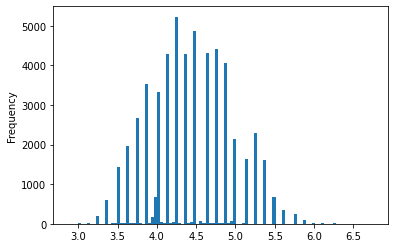

In [ ]:
df_orig['o_int_rate'].plot(kind='hist', bins=100)

#### Original Loan-to-Value (LTV)

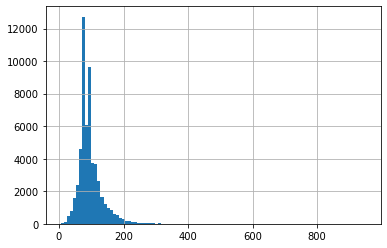

In [ ]:
df_orig['o_ltv'].hist(bins=100)

In [ ]:
## 999: unknown
# df_orig.loc[df_orig['o_ltv']==999, 'o_ltv'] = df_orig['o_ltv'].median()
# df_orig.loc[df_orig['o_ltv']==999, :] 

## remove loan idxes that have unknown ltv
loan_idxes_to_del.update(df_orig.loc[df_orig['o_ltv']==999, 'loan_id'].values.tolist())

#### Original Combined Loan-to-Value (CLTV)

In [ ]:
df_orig[['o_ltv', 'o_cltv']].corr()

,o_ltv,o_cltv
o_ltv,1.000000,0.954757
o_cltv,0.954757,1.000000


In [ ]:
# df_orig.drop(columns=['o_cltv'], inplace=True, errors='ignore')
cols_to_del.append('o_cltv')

#### Original UPB: unpaid balance

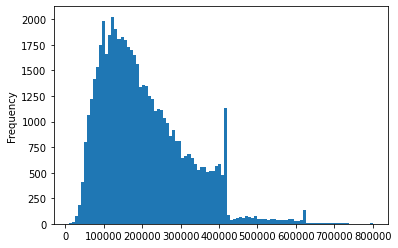

In [ ]:
df_orig['o_upb'].plot(kind='hist', bins=100)

#### Original Debt-to-Income (DTI) Ratio

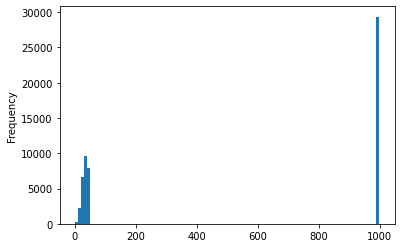

In [ ]:
df_orig['o_dti'].plot(kind='hist', bins=100)

In [ ]:
df_orig['o_dti'].describe()

count    55874.000000
mean       541.154634
std        481.924424
min          1.000000
25%         36.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: o_dti, dtype: float64

In [ ]:
df_orig.loc[df_orig['o_dti']==999, :]

,o_credit_score,o_init_pay_d,o_first_flag,o_mat_d,o_msa,o_mi,o_units,o_occ_stat,o_cltv,o_dti,o_upb,o_ltv,o_int_rate,o_chan,o_ppm,o_amtz_type,o_prop_st,o_prop_type,o_zip,loan_id,o_purp,o_term,o_num_brwrs,o_prgm_ind,o_harp_ind,o_pt_val_md,o_int_only,o_ind_sup_cfm
21,694,201103,9,204102,29620.0,25,1,P,115,999,250000,93,5.000,R,N,FRM,MI,SF,48900,F11Q10003033,N,360,2,9,Y,9,N,0
44,765,201103,9,204102,19804.0,30,1,P,110,999,154000,110,4.875,R,N,FRM,MI,SF,48100,F11Q10004853,N,360,2,9,Y,9,N,0
62,674,201104,9,204103,28140.0,0,1,P,95,999,86000,47,5.375,R,N,FRM,KS,SF,66000,F11Q10006452,N,360,2,9,Y,9,N,0
98,717,201103,9,204102,NaN,0,1,P,98,999,269000,98,4.750,R,N,FRM,WA,SF,98000,F11Q10011216,N,360,1,9,Y,9,N,0
121,743,201103,9,204102,NaN,30,1,P,88,999,217000,88,5.125,R,N,FRM,VT,SF,5800,F11Q10014691,N,360,2,9,Y,9,N,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73255,683,201808,9,204807,NaN,0,1,I,146,999,153000,146,5.625,R,N,FRM,SC,CO,29500,F18Q20255741,N,360,2,0,Y,2,N,0
73281,726,201808,9,204807,12580.0,0,1,I,74,999,107000,74,5.375,C,N,FRM,MD,SF,21200,F18Q20350528,N,360,1,0,Y,3,N,0
73443,563,201811,9,204810,NaN,0,1,I,141,999,63000,141,4.875,R,N,FRM,IL,SF,60600,F18Q30327000,N,360,2,0,Y,2,N,0
73495,628,201812,9,204811,NaN,0,1,I,82,999,88000,82,5.750,R,N,FRM,AZ,SF,86400,F18Q40011972,N,360,1,0,Y,3,N,0


In [ ]:
## remove loan idxes that have unknown dti
loan_idxes_to_del.update(df_orig.loc[df_orig['o_dti']==999, 'loan_id'].values.tolist())

#### Occupancy Status

In [ ]:
df_orig['o_occ_stat'].value_counts(dropna=False)

P    48169
I     6009
S     1696
Name: o_occ_stat, dtype: int64

In [ ]:
df_orig.loc[df_orig['o_occ_stat']=='9', 'o_occ_stat'] = 'unknown'

In [ ]:
df_orig['o_occ_stat'].value_counts(dropna=False)

P    48169
I     6009
S     1696
Name: o_occ_stat, dtype: int64

#### Amortization Type

In [ ]:
df_orig.head()

,o_credit_score,o_init_pay_d,o_first_flag,o_mat_d,o_msa,o_mi,o_units,o_occ_stat,o_cltv,o_dti,o_upb,o_ltv,o_int_rate,o_chan,o_ppm,o_amtz_type,o_prop_st,o_prop_type,o_zip,loan_id,o_purp,o_term,o_num_brwrs,o_prgm_ind,o_harp_ind,o_pt_val_md,o_int_only,o_ind_sup_cfm
6,767,201103,9,204102,38900.0,25,1,P,90,39,261000,90,4.375,R,N,FRM,OR,SF,97200,F11Q10001082,N,360,1,9,NaN,9,N,0
7,710,201103,9,204102,38900.0,0,1,P,95,33,224000,80,4.375,R,N,FRM,OR,SF,97200,F11Q10001104,N,360,1,9,NaN,9,N,0
9,739,201103,9,204102,48900.0,30,1,P,95,29,165000,95,4.375,R,N,FRM,NC,SF,28400,F11Q10001291,N,360,2,9,NaN,9,N,0
11,769,201103,9,204102,19500.0,0,1,P,72,23,144000,72,4.625,R,N,FRM,IL,SF,62500,F11Q10001944,C,360,2,9,NaN,9,N,0
12,784,201103,9,204102,30700.0,0,1,P,83,20,142000,77,4.625,R,N,FRM,NE,SF,68500,F11Q10002098,N,360,2,9,NaN,9,N,0


In [ ]:
df_orig['o_amtz_type'].value_counts(dropna=False)

FRM    55874
Name: o_amtz_type, dtype: int64

In [ ]:
cols_to_del.append('o_amtz_type')

#### Mortgage Insurance Percentage

In [ ]:
df_orig['o_mi'].describe()

count    55874.000000
mean         7.450460
std         12.122905
min          0.000000
25%          0.000000
50%          0.000000
75%         20.000000
max         40.000000
Name: o_mi, dtype: float64

In [ ]:
## mark 999 as missing value
df_orig.loc[df_orig['o_mi']==999, 'o_mi'] = np.nan
df_orig.loc[df_orig['o_mi'].isnull(), 'o_mi'] = df_orig['o_mi'].fillna(df_orig['o_mi'].median())

#### Channel

In [ ]:
df_orig['o_chan'].value_counts(dropna=False)

R    40581
C    11594
B     3699
Name: o_chan, dtype: int64

#### First Time Homebuyer Flag

In [ ]:
df_orig['o_first_flag'].value_counts(dropna=False)

9    43641
N     7258
Y     4975
Name: o_first_flag, dtype: int64

In [ ]:
df_orig.loc[df_orig['o_first_flag']=='9', 'o_first_flag'] = 'unknown'

#### Interest Only (I/O) Indicator

In [ ]:
df_orig['o_int_only'].value_counts(dropna=False)

N    55874
Name: o_int_only, dtype: int64

In [ ]:
cols_to_del.append('o_int_only')

#### HARP Indicator

In [ ]:
df_orig['o_harp_ind'].value_counts(dropna=False)

Y      29363
NaN    26511
Name: o_harp_ind, dtype: int64

In [ ]:
## remove loan idxes that are HARP 
loan_idxes_to_del.update(df_orig.loc[df_orig['o_harp_ind']=='Y', 'loan_id'].values.tolist())
cols_to_del.append('o_harp_ind')

#### Delete columns

In [ ]:
# cols_to_del
df_orig.drop(columns=cols_to_del, inplace=True, errors='ignore')

#### Check NA values

In [ ]:
percent_missing = pd.DataFrame(df_orig.isnull().sum()*100/ len(df_orig), columns=['missing percentage'])
percent_missing.sort_values(by='missing percentage', ascending=False, inplace=True)
percent_missing

,missing percentage
o_credit_score,0.0
o_init_pay_d,0.0
o_pt_val_md,0.0
o_prgm_ind,0.0
o_num_brwrs,0.0
o_term,0.0
o_purp,0.0
loan_id,0.0
o_zip,0.0
o_prop_type,0.0


### Select features

In [ ]:
df_orig.columns

Index(['o_credit_score', 'o_init_pay_d', 'o_first_flag', 'o_mat_d', 'o_mi',
       'o_units', 'o_occ_stat', 'o_dti', 'o_upb', 'o_ltv', 'o_int_rate',
       'o_chan', 'o_prop_st', 'o_prop_type', 'o_zip', 'loan_id', 'o_purp',
       'o_term', 'o_num_brwrs', 'o_prgm_ind', 'o_pt_val_md', 'o_ind_sup_cfm'],
      dtype='object')

In [ ]:
keep_features = [
                 ## loan
                 'loan_id', 'o_init_pay_d', 'o_term', 
                 'o_upb', 'o_mi', 'o_ltv', 'o_int_rate', 
                 'o_chan', 'o_purp', 'o_ind_sup_cfm',
                 ## borrower
                 'o_credit_score', 'o_first_flag', 
                 'o_dti', 'o_num_brwrs',
                 ## property
                 'o_units', 'o_occ_stat', 'o_prop_st',
                 'o_prop_type', 'o_pt_val_md'
                 ]

In [ ]:
df_orig = df_orig.loc[:, keep_features]
df_orig.head()

,loan_id,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md
6,F11Q10001082,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9
7,F11Q10001104,201103,360,224000,0.0,80,4.375,R,N,0,710,unknown,33,1,1,P,OR,SF,9
9,F11Q10001291,201103,360,165000,30.0,95,4.375,R,N,0,739,unknown,29,2,1,P,NC,SF,9
11,F11Q10001944,201103,360,144000,0.0,72,4.625,R,C,0,769,unknown,23,2,1,P,IL,SF,9
12,F11Q10002098,201103,360,142000,0.0,77,4.625,R,N,0,784,unknown,20,2,1,P,NE,SF,9


In [ ]:
df_orig.shape

(55874, 19)

In [ ]:
selected_loan_idxes = set(df_orig['loan_id'].unique().tolist())
len(selected_loan_idxes)

55874

## Data Preprocessing for Monthly Performance Data

In [ ]:
percent_missing = pd.DataFrame(df_monthly.isnull().sum()*100/ len(df_monthly), columns=['missing percentage'])
percent_missing.sort_values(by='missing percentage', ascending=False, inplace=True)
percent_missing

,missing percentage
delq_by_disaster,99.791081
zero_bal_code,97.837801
est_ltv,79.596493
loan_id,0.000000
rep_period,0.000000
actual_upb,0.000000
loan_status,0.000000
loan_age,0.000000
remaining_months,0.000000
int_rate,0.000000


#### Delinquency Due to Disaster

In [ ]:
df_monthly.loc[df_monthly['delq_by_disaster'].notnull(), 'delq_by_disaster'] = 1
df_monthly.loc[df_monthly['delq_by_disaster'].isnull(), 'delq_by_disaster'] = 0

df_monthly['delq_by_disaster'].value_counts(dropna=False)

0    3398031
1       7114
Name: delq_by_disaster, dtype: int64

#### Estimated Loan-to-Value (ELTV)

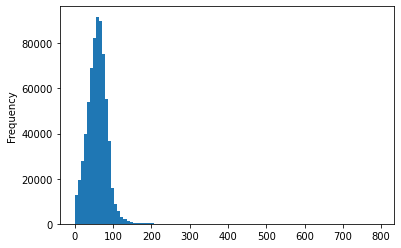

In [ ]:
df_monthly['est_ltv'].plot(kind='hist', bins=100)

In [ ]:
# len(loan_idxes_to_del)

In [ ]:
# # df_monthly.loc[df_monthly['est_ltv'].isnull(), 'loan_id']
# ## remove loan idxes that have unknown est_ltv
# loan_idxes_to_del.update(df_monthly.loc[df_monthly['est_ltv'].isnull(), 'loan_id'].values.tolist())

In [ ]:
# len(loan_idxes_to_del)

#### Current Loan Delinquency Status

remove loan id such that it has R as its loan status

In [ ]:
df_monthly.loc[df_monthly['loan_status']=='0', 'loan_status'] = 0
df_monthly.loc[df_monthly['loan_status']=='R', 'loan_status'] = -1
loan_idxes_to_del.update(df_monthly.loc[df_monthly['loan_status']==-1, 'loan_id'].values)

df_monthly['loan_status'] = df_monthly['loan_status'].apply(np.int)
len(loan_idxes_to_del)

35603

In [ ]:
df_monthly['loan_status'].value_counts(dropna=False)

 0      2797358
 1        84947
 2        53503
 3        43523
 4        40496
         ...   
 87           2
 88           2
 89           2
-2            2
 131          1
Name: loan_status, Length: 93, dtype: int64

## Check valid loan id
A valid loan id must have a valid monthly performance sequence, where the loan age starts with 0 and is consecutive. 

In [ ]:
df_orig = df_orig.loc[~df_orig['loan_id'].isin(loan_idxes_to_del), :]
df_monthly = df_monthly.loc[~df_monthly['loan_id'].isin(loan_idxes_to_del), :]

print("df_orig.shape", df_orig.shape)
print("df_monthly.shape", df_monthly.shape)

df_orig.shape (22589, 19)
df_monthly.shape (1807734, 10)


In [ ]:
selected_loan_idxes = df_orig['loan_id'].values.tolist()
# selected_loan_idxes

In [ ]:
def check_valid_seq(df, col):
    '''
    a valid loan monthly performance sequence satisfies:
    1) starts with age 0
    2) loan ages are consecutive
    '''
    seq = sorted(list(df.loc[:, col].values))
    # print(seq)
    # print(list(range(len(seq))))
    res = seq==list(range(len(seq)))
    # print('res', res)
    return res

In [ ]:
%%time
invalid_loan_idxes = set()
for i, loan_id in enumerate(selected_loan_idxes):
    df_m = df_monthly.loc[df_monthly['loan_id']==loan_id, :]
    if not check_valid_seq(df_m, 'loan_age'):
        invalid_loan_idxes.add(loan_id)
    if i%2000==0:
        print('{} loans have been checked'.format(i))


0 loans have been checked
2000 loans have been checked
4000 loans have been checked
6000 loans have been checked
8000 loans have been checked
10000 loans have been checked
12000 loans have been checked
14000 loans have been checked
16000 loans have been checked
18000 loans have been checked
20000 loans have been checked
22000 loans have been checked
CPU times: user 45min 27s, sys: 6.95 s, total: 45min 34s
Wall time: 45min 27s


In [ ]:
len(invalid_loan_idxes)

2536

In [ ]:
df_orig = df_orig.loc[~df_orig['loan_id'].isin(invalid_loan_idxes), :]
df_monthly = df_monthly.loc[~df_monthly['loan_id'].isin(invalid_loan_idxes), :]

print("df_orig.shape", df_orig.shape)
print("df_monthly.shape", df_monthly.shape)

df_orig.shape (20053, 19)
df_monthly.shape (1694602, 10)


Sample data

In [ ]:
# np.random.seed(42)
# rand_loan_idx = np.random.choice(np.array(list(selected_loan_idxes)), 1)[0]
rand_loan_idx = df_orig.sample(1, random_state=42)['loan_id'].values[0]
rand_loan_idx


'F12Q40114355'

In [ ]:
df_orig.loc[df_orig['loan_id']==rand_loan_idx, :]

,loan_id,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md
35372,F12Q40114355,201212,360,405000,0.0,73,3.625,C,N,0,736,unknown,37,2,1,P,IL,SF,9


In [ ]:
df_monthly.loc[df_monthly['loan_id']==rand_loan_idx, :]

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster
1731624,F12Q40114355,201211,405000.00,0,0,360,NaN,3.625,NaN,0
1731625,F12Q40114355,201212,404000.00,0,1,359,NaN,3.625,NaN,0
1731626,F12Q40114355,201301,404000.00,0,2,358,NaN,3.625,NaN,0
1731627,F12Q40114355,201302,403000.00,0,3,357,NaN,3.625,NaN,0
1731628,F12Q40114355,201303,402000.00,0,4,356,NaN,3.625,NaN,0
1731629,F12Q40114355,201304,402000.00,0,5,355,NaN,3.625,NaN,0
1731630,F12Q40114355,201305,401000.00,0,6,354,NaN,3.625,NaN,0
1731631,F12Q40114355,201306,400595.23,0,7,353,NaN,3.625,NaN,0
1731632,F12Q40114355,201307,399958.35,0,8,352,NaN,3.625,NaN,0
1731633,F12Q40114355,201308,399319.55,0,9,351,NaN,3.625,NaN,0


In [ ]:
df_orig.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20053 entries, 6 to 73625
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loan_id         20053 non-null  object 
 1   o_init_pay_d    20053 non-null  int64  
 2   o_term          20053 non-null  int64  
 3   o_upb           20053 non-null  int64  
 4   o_mi            20053 non-null  float64
 5   o_ltv           20053 non-null  int64  
 6   o_int_rate      20053 non-null  float64
 7   o_chan          20053 non-null  object 
 8   o_purp          20053 non-null  object 
 9   o_ind_sup_cfm   20053 non-null  int64  
 10  o_credit_score  20053 non-null  int64  
 11  o_first_flag    20053 non-null  object 
 12  o_dti           20053 non-null  int64  
 13  o_num_brwrs     20053 non-null  int64  
 14  o_units         20053 non-null  int64  
 15  o_occ_stat      20053 non-null  object 
 16  o_prop_st       20053 non-null  object 
 17  o_prop_type     20053 non-null 

In [ ]:
df_monthly.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1694602 entries, 0 to 3405144
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   loan_id           object 
 1   rep_period        int64  
 2   actual_upb        float64
 3   loan_status       int64  
 4   loan_age          int64  
 5   remaining_months  int64  
 6   zero_bal_code     float64
 7   int_rate          float64
 8   est_ltv           float64
 9   delq_by_disaster  object 
dtypes: float64(4), int64(4), object(2)
memory usage: 142.2+ MB


## Save data 

In [ ]:
now = datetime.now()
# print(now)

utc = pytz.utc
utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
eastern = pytz.timezone('US/Eastern')
loc_dt = utc_dt.astimezone(eastern)
fmt = '%Y%m%d_%H%M'
cur_datetime = loc_dt.strftime(fmt)
cur_datetime

'20210803_2235'

In [ ]:
# file_name = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/data_orig_2011_2019_pre_chg_"
# df_orig.to_csv(file_name+cur_datetime+'.csv')
# # print(file_name+cur_datetime+'.csv')

In [ ]:
# file_name = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/data_monthly_2011_2019_pre_chg_"
# df_monthly.to_csv(file_name+cur_datetime+'.csv')
# # print(file_name+cur_datetime+'.csv')